Load Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("",train=True,transform=transforms.ToTensor(),
                      target_transform=None, download=True)
mnist_test = dset.MNIST("",train=False,transform=transforms.ToTensor(),
                      target_transform=None, download=True)

대략적인 데이터 형태

('mnist_train \xea\xb8\xb8\xec\x9d\xb4 :', 60000)
('mnist_test \xea\xb8\xb8\xec\x9d\xb4 :', 10000)
('image data \xed\x98\x95\xed\x83\x9c:', torch.Size([1, 28, 28]))
('label:', 5)


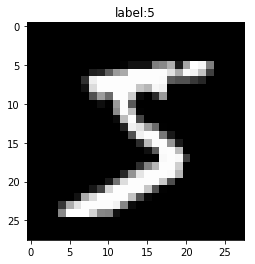

In [3]:
print("mnist_train 길이 :", len(mnist_train))
print("mnist_test 길이 :",len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태:", image.size())
print("label:",label)

#그리기
img = image.numpy() #image 타입을 numpy로 변환 (1,28,28)
plt.title("label:%d"%label)
plt.imshow(img[0],cmap='gray')
plt.show()

MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


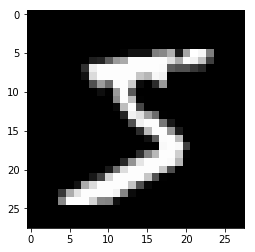

0


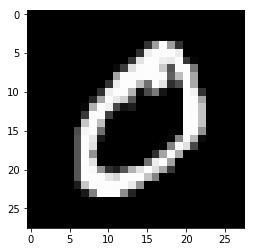

4


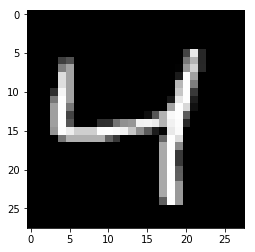

In [4]:
print(mnist_train[0][1]) #label
print(mnist_train[0][0].size()) #image

for i in range(3):
    img = mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0],cmap='gray')
    plt.show()

convolution 하나 씌워보기

5
torch.Size([1, 3, 28, 28])


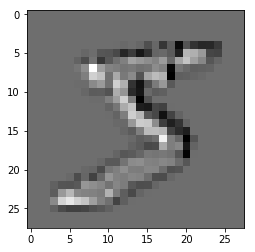

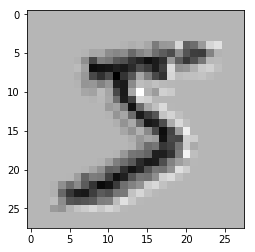

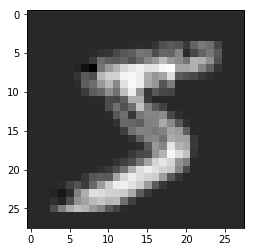

In [5]:
#mnist의 첫 번째 이미지, 라벨 갸져오기
image, label = mnist_train[0]
#view : tensor의 사이즈 조절, -1 : 해당 차원 확장시켜라
# [1,28,28] -> [1,1,28,28]
image = image.view(-1, image.size()[0],image.size()[1],image.size()[2])

print label

#convolutional filter 정의
conv_layer = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,padding=1)
#image에 filter 적용
output = conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

CNN 만들기

train, test data 가져오기

In [6]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10 # 1000

In [7]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size, #mnist를 train시키자
                                            shuffle=True, num_workers=2,
                                          drop_last=True) #batch_size만큼 나눌 때 나머지는 버려라
test_loader = torch.utils.data.DataLoader((mnist_test),batch_size=batch_size, 
                                            shuffle=False, num_workers=2,
                                          drop_last=True)

CNN 클래스 만들기 (모델 만들기)

In [8]:
class CNN(nn.Module): #nn.Module 상속받음
    def __init__(self):
        super(CNN,self).__init__() #28x28
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(16,32,5,padding=2), #28x28
            nn.ReLU(),
            nn.MaxPool2d(2,2), #28x28 -> #14x14
            
            nn.Conv2d(32,64,5, padding=2), #14x14
            nn.ReLU(),
            nn.MaxPool2d(2,2) #14x14 -> 7x7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out
    
model = CNN() #.cuda()


In [9]:
# 파라미터 체크하기
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [10]:
#loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

Optimization

In [11]:
for i in range(num_epoch):
    for j, [image,label] in enumerate(train_loader): #batch_size 만큼
        x = Variable(image) #.cuda()
        y_ = Variable(label) #.cuda()
        
        optimizer.zero_grad() #optimizer 안에서 이전 gradient들을 초기화
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward() #gradient 계산
        optimizer.step() #parameter 업데이트
        
        if j%50 ==0:
            print(loss,j,i)

(tensor(2.2935, grad_fn=<NllLossBackward>), 0, 0)
(tensor(1.9887, grad_fn=<NllLossBackward>), 50, 0)
(tensor(0.7981, grad_fn=<NllLossBackward>), 0, 1)
(tensor(0.6853, grad_fn=<NllLossBackward>), 50, 1)
(tensor(0.6997, grad_fn=<NllLossBackward>), 0, 2)
(tensor(0.1870, grad_fn=<NllLossBackward>), 50, 2)
(tensor(0.4871, grad_fn=<NllLossBackward>), 0, 3)
(tensor(0.2189, grad_fn=<NllLossBackward>), 50, 3)
(tensor(0.3188, grad_fn=<NllLossBackward>), 0, 4)
(tensor(0.1869, grad_fn=<NllLossBackward>), 50, 4)
(tensor(0.3022, grad_fn=<NllLossBackward>), 0, 5)
(tensor(0.0942, grad_fn=<NllLossBackward>), 50, 5)
(tensor(0.0260, grad_fn=<NllLossBackward>), 0, 6)
(tensor(0.2319, grad_fn=<NllLossBackward>), 50, 6)
(tensor(0.0305, grad_fn=<NllLossBackward>), 0, 7)
(tensor(0.0953, grad_fn=<NllLossBackward>), 50, 7)
(tensor(0.0705, grad_fn=<NllLossBackward>), 0, 8)
(tensor(0.0990, grad_fn=<NllLossBackward>), 50, 8)
(tensor(0.0441, grad_fn=<NllLossBackward>), 0, 9)
(tensor(0.0323, grad_fn=<NllLossBackward>

In [22]:
torch.save(model,'C:/Users/eunyoung/github/mycnn_model_%d.pkl'%(num_epoch))

IOError: [Errno 2] No such file or directory: 'C:/Users/eunyoung/github/mycnn_model_10.pkl'

In [23]:
try:
    #미리 학습시킨 네트워크의 파라미터 집합 [피클]이라 발음함.
    model=torch.load('C:/Users/eunyoung/github/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model not restored


In [24]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        img = Variable(imgs) #.cuda() #x
        label = Variable(labels) #y
        #label = Variable(labels).cuda()
        # .cuda() : GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남남
        
        output = imodel.forward(img) #forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data:{}".format(100*correct/total))

In [25]:
ComputeAccr(test_loader, model)

Accuracy of Test Data:94.9000015259
